In [184]:
import pykat
import numpy as np
import pandas
import matplotlib.pyplot as pl
from scipy import stats

%matplotlib inline

In [262]:
kat_code = """
l L0 1 0 n0 

s lbs 0 n0 n1

bs1 bssource 0.5 0 0 45 n1 n2 dump nhws

s sbstolens1 2.7057 n2 nlens1in

lens len1 1.6994 nlens1in nlens1out

s slens1tolens2 2.8092 nlens1out nlens2in

lens len2 -1.6994 nlens2in nlens2out

s slenstoSR3 17.3953 nlens2out nSR3in

bs1 SR3 0 0 0 0.785 nSR3in nSR3out dump dump

attr SR3 Rc 35.972841

s SR3toBS 19.3661 nSR3out nBSin 

#AR surface
bs1 BS 0 0 0 45 nBSin nBSout dump dump

s BStoITMX1 5.2882 nBSout nITMXin

#ITM
m1 ITMHR 1u 0 0 nITMXin nITMXout
attr ITMHR Rc -1934
#HWS 
s sbs1toHWS 2.7057 nhws nhwsout

pd HWSa nhwsout
pdtype HWSa y-split

pd HWSb nhwsout
pdtype HWSb y-split

pd ITMXpd nITMXout
pdtype ITMXpd y-split

noxaxis 
"""

In [263]:
basekat = pykat.finesse.kat() 
basekat.parse(kat_code)

kat = basekat.deepcopy()

kat.run()

--------------------------------------------------------------
Running kat - Started at 2018-10-03 13:57:26.935325

Finished in 0.0688167 seconds


100% | ETA:  0:00:00 | Calculating                                             

In [264]:
bs1toHWS = kat.sbs1toHWS.ABCD('nhws','nhwsout')

len1 = kat.len1.ABCD('nlens1in','nlens1out')

slen1tolen2 = kat.slens1tolens2.ABCD('nlens1out','nlens2in')

len2 = kat.len2.ABCD('nlens2in','nlens2out')

slen2toSR3 = kat.slenstoSR3.ABCD('nlens2out','nSR3in')

SR3 = kat.SR3.ABCD('nSR3in','nSR3out')

sSR3toBS = kat.SR3toBS.ABCD('nSR3out','nBSin')

sBStoITMX = kat.BStoITMX1.ABCD('nBSout', 'nITMXin')

ITMX = kat.ITMHR.ABCD('nITMXin', 'nITMXout')

In [265]:
# Create in-out vectors
row = np.arange(-1.0,1.0,1e-2)
zeros = np.zeros(row.shape)

in_v =np.column_stack([zeros,row])
out_v = np.column_stack([zeros,row])

In [306]:
SR3_to_HWS = bs1toHWS * len1 * slen1tolen2 * len2 * slen2toSR3

SR3_to_ITMX_ret = SR3 * sSR3toBS * sBStoITMX *ITMX* sBStoITMX * sSR3toBS

#ITMX_to_HWS = bs1toHWS* len1 * slen1tolen2 * len2 * slen2toSR3 * SR3 * sSR3toBS * sBStoITMX

m = np.matrix(SR3_to_HWS*SR3_to_ITMX_ret)

print(m)

#m = np.matrix(ITMX_to_HWS)

for i  in range(len(in_v)):
    out_v[i] = np.dot(m,in_v[i])


print(out_v[0],in_v[0])

[[-5.72579502e-02 -1.41327522e+00]
 [ 4.43134837e-03 -1.73554464e+01]]
[ 1.41327522 17.35544638] [ 0. -1.]


In [307]:
print(SR3_to_ITMX_ret)

print(SR3_to_HWS)

[[ 1.         49.3086    ]
 [-0.05560272 -1.74169217]]
[[  0.02114378   1.41003415]
 [ -0.97272803 -17.57394997]]


In [308]:
check ="""### To make sure the sign of the SR3 is correct, inject into flat, sh
SR3_to_ITMX_ret_flat = sSR3toBS * sBStoITMX * sBStoITMX * sSR3toBS

out_check = np.column_stack([zeros,row])
in_check = np.column_stack([zeros,row])

for i  in range(len(in_v)):
    out_check[i] = np.dot(SR3_to_ITMX_ret_flat,in_check[i])

pl.figure(figsize=(15, 5), dpi=80)

pl.subplot(121)

pl.plot(row,out_check[:,0], 'o',linewidth=3)

pl.xlabel("SR3 Optic Tilt(rad)")
pl.ylabel("On HWS (m)")

#Main plot formatting
pl.tick_params(labelsize=12)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=15)

pl.subplot(122)
pl.plot(row,out_check[:,1], 'o',linewidth=3)

pl.xlabel("SR3 Optic Tilt(rad)")
pl.ylabel("On HWS (rad)")

#Main plot formatting
pl.tick_params(labelsize=12)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=15)

pl.show()"""

In [309]:
def slope_finder(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return slope

s_dis = round(slope_finder(row,out_v[:,0]),3)
s_ang = round(slope_finder(row,out_v[:,1]),3)

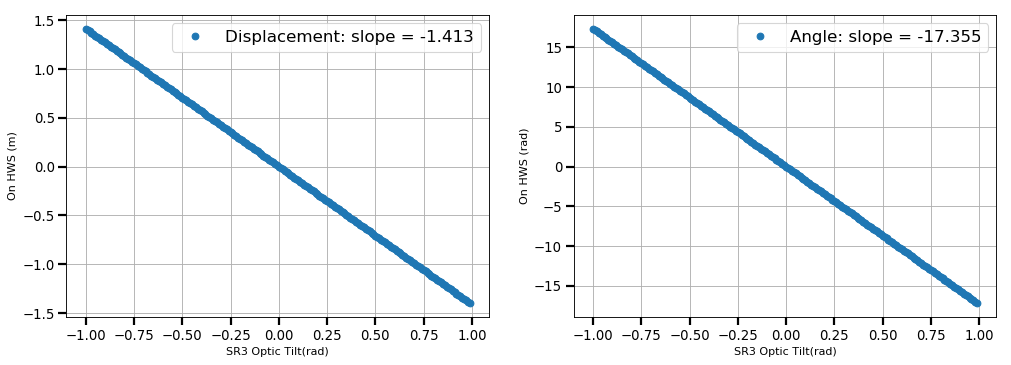

In [313]:
pl.figure(figsize=(15, 5), dpi=80)

pl.subplot(121)

pl.plot(row,out_v[:,0], 'o',linewidth=3,label='Displacement: slope = '+ str(s_dis))

pl.xlabel("SR3 Optic Tilt(rad)")
pl.ylabel("On HWS (m)")

#Main plot formatting
pl.tick_params(labelsize=12)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=15)

pl.subplot(122)
pl.plot(row,out_v[:,1], 'o',linewidth=3,label='Angle: slope = '+ str(s_ang))

pl.xlabel("SR3 Optic Tilt(rad)")
pl.ylabel("On HWS (rad)")

#Main plot formatting
pl.tick_params(labelsize=12)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=15)

pl.savefig('SR3toHWSx_sensitivity.png')
pl.show()

In [311]:
#Does this match Aidan's estimate, D should be -17.5 and B should be close to zero
ITMX_to_HWS = bs1toHWS* len1 * slen1tolen2 * len2 * slen2toSR3 * SR3 * sSR3toBS * sBStoITMX

print(ITMX_to_HWS)

[[-5.72579502e-02 -1.62053624e-03]
 [ 4.43134837e-03 -1.74646982e+01]]
